# 2. model training

## imports

In [522]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from sklearn.externals import joblib

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

%matplotlib inline

In [523]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

# import useful functions from the source code
%aimport features.build_features
from features.build_features import preprocess, create_features

%aimport models.train_model
from models.train_model import prep_x_and_y, rf_feature_importances_single, rf_feature_importances_by_city,\
run_tree_models,run_grid_search_rf, calculate_mae_for_train, fit_final_model, create_results_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## start with pre-processed data

In [528]:
# same pre-processing as what was done in previous notebook
df = preprocess('../data/raw/dengue_features_train.csv', '../data/raw/dengue_labels_train.csv')
df = create_features(df, 'train')

# alternately load
# df = pd.read_pickle('../data/processed/train.pkl')

In [529]:
df.head()

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,sj,month,day,yr
0,4,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,2.628571,25.442857,6.900000,29.4,20.0,16.0,1,4,30,1990
1,5,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,2.371429,26.714286,6.371429,31.7,22.2,8.6,1,5,7,1990
2,4,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,2.300000,26.714286,6.485714,32.2,22.8,41.4,1,5,14,1990
3,3,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,2.428571,27.471429,6.771429,33.3,23.3,4.0,1,5,21,1990
4,6,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,3.014286,28.942857,9.371429,35.0,23.9,5.8,1,5,28,1990


## out of the box random forest

In [484]:
rf_feature_importances_single(df)

Mean absolute error: 12.035469107551487

('ndvi_sw', 0.2344468165755061)
('yr', 0.21213822730473159)
('month', 0.16177410838287148)
('ndvi_se', 0.08336176730500672)
('reanalysis_dew_point_temp_k', 0.040951122709522204)
('reanalysis_specific_humidity_g_per_kg', 0.03444400968204927)
('ndvi_ne', 0.03154361892167858)
('station_max_temp_c', 0.025258690536905715)
('reanalysis_relative_humidity_percent', 0.020922270503654826)
('ndvi_nw', 0.019545944642378847)
('reanalysis_precip_amt_kg_per_m2', 0.019318949184547775)
('reanalysis_max_air_temp_k', 0.01572609579904729)
('reanalysis_tdtr_k', 0.013272353621693798)
('station_min_temp_c', 0.011521960419505924)
('day', 0.011381650452390013)
('reanalysis_min_air_temp_k', 0.011010938083126805)
('reanalysis_air_temp_k', 0.010206056533964121)
('reanalysis_avg_temp_k', 0.009950400463917323)
('station_avg_temp_c', 0.009053540575555222)
('station_diur_temp_rng_c', 0.008878592855638084)
('station_precip_mm', 0.007748834943201746)
('precipitation_amt_mm', 0.0

In [485]:
# this looks very promising for a decision tree approach

In [486]:
# do we need a random forest run on each city separately or will one random forest suffice?
# features visualizations in previous file indicate it could be helpful..
# but city is least helpful feature in above random forest.

### random forest models trained independently on each city

In [487]:
rf_feature_importances_by_city(df)

('yr', 0.4244495497061722)
('month', 0.14773950753988532)
('reanalysis_dew_point_temp_k', 0.04988473540111973)
('station_max_temp_c', 0.04201170580498172)
('reanalysis_max_air_temp_k', 0.03369766081967256)
('reanalysis_specific_humidity_g_per_kg', 0.032734313777597016)
('ndvi_se', 0.03257764834094254)
('ndvi_sw', 0.02678391216508393)
('ndvi_nw', 0.025799747128983898)
('reanalysis_tdtr_k', 0.02505504643738906)
('station_avg_temp_c', 0.02463402943947253)
('reanalysis_precip_amt_kg_per_m2', 0.020368507551714)
('reanalysis_relative_humidity_percent', 0.016735889490044953)
('reanalysis_avg_temp_k', 0.015748570646300537)
('ndvi_ne', 0.012794331646724841)
('station_min_temp_c', 0.011390837221215106)
('precipitation_amt_mm', 0.01071449878234)
('station_diur_temp_rng_c', 0.010619498419570555)
('reanalysis_air_temp_k', 0.009689483853843803)
('reanalysis_sat_precip_amt_mm', 0.009587006086017234)
('station_precip_mm', 0.006899134670286825)
('day', 0.0050911343828969995)
('reanalysis_min_air_temp_k

In [488]:
# mean absolute error is higher with the individual models; will stick with one random forest for the entire df
### note: this assumption later turns out to be wrong and separate models are created

## cycling through a dictionary of tree models

In [489]:
# let's see if other tree models perform better than random forest

In [490]:
X, y, X_train, X_test, y_train, y_test = prep_x_and_y(df)

In [491]:
run_tree_models(X_train, X_test, y_train, y_test)

Model: dt
Mean absolute error: 13.153318077803204

Model: extratrees
Mean absolute error: 16.704805491990847

Model: randomForest
Mean absolute error: 11.814187643020595

Model: bagged_randomForest
Mean absolute error: 11.76803203661327

Model: adaboostedTrees
Mean absolute error: 27.200086137571752

Model: gradboostedTrees
Mean absolute error: 12.042629578515914



In [396]:
# top three are random forest, bagged RF, and gradient boosted trees
# for simplicity and speed of training, let's stick with random forest

## setting hyperparameters (grid search)

In [492]:
rf = RandomForestRegressor(random_state=42)

params = {'n_estimators': [10, 20, 50, 100], 'min_samples_split': [2, 5, 10, 20], \
          'min_samples_leaf': [1, 2, 10], 'max_depth': [1, 2, 5, 10, 50]}

# cross validated grid search so using entire X and y rather than train/test
grid_dict = GridSearchCV(rf, params, verbose = 1, scoring = make_scorer(mean_absolute_error), n_jobs = 2)
train_fit = grid_dict.fit(X, y)
print('Best Score: %0.3f' % train_fit.best_score_)
print('Optimal Parameters: ', train_fit.best_params_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:   15.1s
[Parallel(n_jobs=2)]: Done 464 tasks      | elapsed:   46.4s
[Parallel(n_jobs=2)]: Done 714 tasks      | elapsed:  1.6min


Best Score: 23.938
Optimal Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:  1.7min finished


## visualize predictions of best model

In [493]:
final_model = RandomForestRegressor(**train_fit.best_params_)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print("Mean absolute error: " + str(mean_absolute_error(y_test, y_pred)))

Mean absolute error: 12.38491512740231


In [494]:
# refit on entire data
fitted_model = final_model.fit(X, y)
y_pred = fitted_model.predict(X)
print("Mean absolute error: " + str(mean_absolute_error(y, y_pred)))

Mean absolute error: 6.392506360403424


In [495]:
# set up results dataframe
results_df = df[['total_cases', 'sj']]

In [498]:
# predict
results_df['predictions'] = fitted_model.predict(X)

/Users/braeburn/.virtualenvs/dengai-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


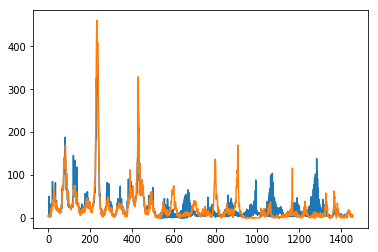

In [499]:
# plot predictions
results_df.predictions.plot(label="Predictions")
results_df.total_cases.plot(label="Actual")

In [500]:
# this is hard to tell where the model is doing well and where it's doing poorly
# let's separate by city to get a better view

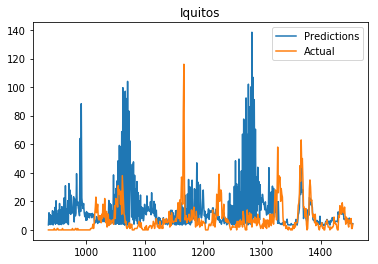

In [501]:
# for IQ
results_df[results_df.sj==0].predictions.plot(label="Predictions", legend= True)
results_df[results_df.sj==0].total_cases.plot(label="Actual", legend = True)
plt.title('Iquitos');

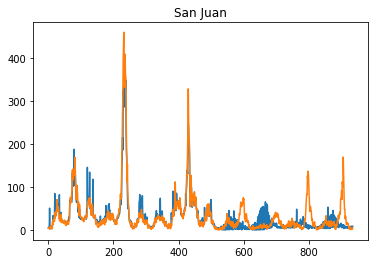

In [502]:
# for SJ
results_df[results_df.sj==1].predictions.plot(label="Predictions")
results_df[results_df.sj==1].total_cases.plot(label="Actual")
plt.title('San Juan');

In [503]:
# so this model seems to be doing pretty well for SJ but not very well for IQ
# let's revisit the idea of having a model by city

## re-doing above analysis for Iquitos

In [504]:
# running this time with functions for simplicity
# set df.sj==0 to select Iquitos
X, y, X_train, X_test, y_train, y_test = prep_x_and_y(df[df.sj==0])

iq_best_params = run_grid_search_rf(X, y, X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   42.8s finished


Best Score: 7.994
Optimal Parameters:  {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}


In [505]:
# calculate mean absolute error
calculate_mae_for_train(iq_best_params, X_train, X_test, y_train, y_test)

Mean absolute error: 7.967307692307691


In [506]:
# save model
# this function also prints mean absolute error for when the model is trained on the entire dataset
iq_model = fit_final_model(iq_best_params, X, y)

Mean absolute error: 2.2525000000000004


In [507]:
# generate predictions so we can plot
results_iq = create_results_df(iq_model, df[df.sj==0], X)

/Users/braeburn/ds/metis/metisgh/driven_data_dengai/notebooks/../src/models/train_model.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return fitted_model


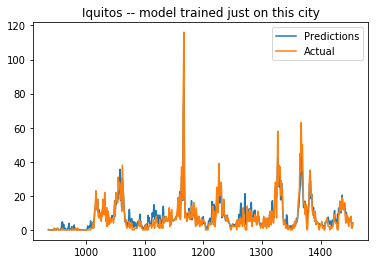

In [508]:
results_iq.predictions.plot(label="Predictions", legend = True)
results_iq.total_cases.plot(label="Actual", legend = True)
plt.title('Iquitos -- model trained just on this city');

In [509]:
# this looks great, let's do the same thing for SJ

## and now for San Juan

In [510]:
# set sj==1 for San Juan
X, y, X_train, X_test, y_train, y_test = prep_x_and_y(df[df.sj==1])

sj_best_params = run_grid_search_rf(X, y, X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:   12.5s


Best Score: 30.580
Optimal Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}


[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:  1.1min finished


In [511]:
# note mean absolute error is higher for san juan (potentially because there's more data points?)
calculate_mae_for_train(sj_best_params, X_train, X_test, y_train, y_test)

Mean absolute error: 20.631517564430467


In [512]:
# save model
sj_model = fit_final_model(sj_best_params, X, y)

Mean absolute error: 7.7419764429065525


In [513]:
# generate predictions to plot
results_sj = create_results_df(sj_model, df[df.sj==1], X)

/Users/braeburn/ds/metis/metisgh/driven_data_dengai/notebooks/../src/models/train_model.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return fitted_model


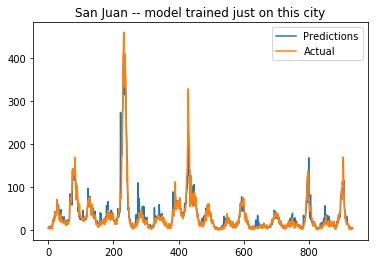

In [514]:
results_sj.predictions.plot(label="Predictions", legend = True)
results_sj.total_cases.plot(label="Actual", legend = True)
plt.title('San Juan -- model trained just on this city');

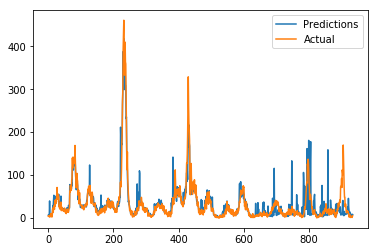

In [515]:
# let's see what model predictions look like when the model is not retrained on the entire data set
final_model = RandomForestRegressor(**sj_best_params)
fitted_model = final_model.fit(X_train, y_train)
results_df = df[['total_cases', 'sj']][df.sj==1]
results_df['predictions'] = fitted_model.predict(X)
results_df.predictions.plot(label="Predictions", legend = True)
results_df.total_cases.plot(label="Actual", legend = True)

# less accurate predictions on final third of data give us a sense of how the model may do on the test data for submission 

In [531]:
# note: this model is fitting the data well but it needs much more feature engineering to generalize well
# it should be interpreted more like a baseline decision tree model

### pickle models

In [516]:
joblib.dump(sj_model, '../models/sj_model.pkl')

['../models/sj_model.pkl']

In [517]:
joblib.dump(iq_model, '../models/iq_model.pkl')

['../models/iq_model.pkl']

## things to improve the model (a starter list):
- significantly more feature engineering is needed to take into account the time dimension 
- smoothing functions may help
- ARIMAX and other time series models (ex. facebook's newly released prophet model) are definitely worth exploring
- may also want to allow for using different models for each city (i.e instead of using random forest for each)